In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../src')
os.chdir('../src')

import warnings
warnings.filterwarnings('ignore')


import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as idp
import librosa
from tqdm import tqdm

import torch.nn.functional as F
import torchaudio.transforms as T


In [ ]:
t

In [147]:
from audio_descriptors.features import compute_all
from raving_fader.helpers.eval import load_model

torch.set_grad_enabled(False)

In [131]:
def get_features(audio,descriptors,sr,latent_length=64):
    feat = compute_all(audio,sr=sr,descriptors=descriptors,
                                            mean=False,
                                            resample=latent_length)
    
    feat = {descr: feat[descr] for descr in descriptors}
    feat = np.array(list(feat.values())).astype(np.float32)
    return(torch.tensor(feat))

def plot_features(features,descriptors,features_2=None):
    f,axs = plt.subplots(1,5,figsize=(20,5))
    for i,ax in enumerate(axs):
        ax.plot(features[i],label="Original")
        
        if features_2 is not None:
            ax.plot(features_2[i],label="Modified")
        # ax.set_ylim(-1,1)
        ax.set_title(descriptors[i])
        ax.legend()
        
def normalize(features,all_features):
    features_normed = torch.clone(features)
    for i in range(features.shape[1]):
        features_normed[:,i] = 2* ( (features[:,i] - np.min(all_features[:,i])) / (np.max(all_features[:,i]) - np.min(all_features[:,i])) -0.5 ) 
    return features_normed


def forward_eval(model,audio,features_normed):
    with torch.no_grad():
        x = audio.to(model.device).unsqueeze(0)
        x = model.pqmf(x)
        z, kl = model.reparametrize(*model.encoder(x))
        # z=torch.zeros_like(z)
        z_c = torch.cat((z, features_normed.to(model.device)), dim=1)
        y = model.decoder(z_c, add_noise=False)
        y = model.pqmf.inverse(y)
        y = y.squeeze()
        return z,y

In [132]:
def create_funcs(features_swapped):
    n_points = 64
    # Lots of basic funcs
    zeros = np.zeros(n_points)
    ones = np.ones(n_points)
    ones_m = np.ones(n_points) * -1 
    linear = np.linspace(-1, 1, n_points)
    linear_inv = np.linspace(1, -1, n_points)
    # Selector array
    basic_funcs = [zeros, ones, ones_m, linear, linear_inv]
    # Sinusoid generator
    sin_funcs = []
    for i in range(10):
        freq = np.random.randint(1, 30)
        phase = np.random.randn() * 2 * np.pi
        sin_rnd = np.sin((linear * freq) + phase)
        sin_funcs.append(sin_rnd)

    # Interpolator
    sel_1 = basic_funcs[np.random.randint(0, len(basic_funcs))]
    sel_2 = sin_funcs[np.random.randint(0, len(sin_funcs))]
    alphas = np.linspace(0., 1., 10)
    int_funcs = []
    for alpha in alphas:
        int_sig = alpha * sel_2 + ((1 - alpha) * sel_1)
        int_funcs.append(int_sig)

    # Interpolator

    sel_1,sel_2 = features_swapped[0],features_swapped[1]
    # plt.plot(sel_1)
    # plt.plot(sel_2)
    alphas = np.linspace(0., 1., 50)
    eval_funcs = []
    for alpha in alphas:
        int_sig = alpha * sel_2 + ((1 - alpha) * sel_1)
        eval_funcs.append(int_sig)

    full_funcs = [torch.tensor(item) for sub in [basic_funcs, sin_funcs, int_funcs, eval_funcs] for item in sub]
    full_funcs=  torch.stack(full_funcs)
    return full_funcs


def swap_features(all_features,features_normed,nb_swap):
    
    
    features_swapped = torch.clone(features_normed)
    
    id_random = np.random.choice(range(len(all_features)),2)
    features_ext = torch.tensor(all_features[id_random,:])
    features_ext = normalize(features_ext,all_features)
    
    
    id_descr = np.random.choice([i for i in range(5)],nb_swap,replace=False)

    
    for j in id_descr:
        features_pool = create_funcs(features_ext[:,j])
        id_random = np.random.choice(range(len(features_pool)),len(x))

        features_swapped[:,j] = features_pool[id_random,:].squeeze(1)
    return features_swapped



In [8]:
dataset_dir = "/data/nils/datasets/nsynth_full_train/"
feat_path = os.path.join(dataset_dir,"features.pth")
wav_path = os.path.join(dataset_dir,"audio")
mdb_path = os.path.join(dataset_dir,"data.mdb")

all_features = torch.load(feat_path)

In [161]:
models_dir = "/data/nils/raving-fader/models/"
model_name = "FRAVE_nsynthfull" 

path = os.path.join(models_dir,model_name)
ckpt = os.path.join(path,model_name+"__vae.ckpt")
config_file = os.path.join(path,"train_config.yaml")
config,pipeline,model,checkpoint=load_model(config_file,ckpt,datapath=None,batch_size=32)
print(checkpoint["step"])

validloader= pipeline.val_set


>>> Device : cuda
289205
begin here
1016000


In [222]:
nb_swap = 5
nb_files = 100


results = {"distance":0,"correlation":{descr:0 for descr in model.descriptors},"l1_loss":{descr:0 for descr in model.descriptors}}
resampler = T.Resample(model.sr, 44100).to(model.device)

for k,(x,features) in tqdm(enumerate(validloader)):
    # Get x and features from dataloader
    x = x.unsqueeze(1).to(model.device)
    
    #Normalize the features 
    features_normed = normalize(features,all_features)
    features_normed = features_normed
    
    
    #Create the swapped features
    features_swapped = swap_features(all_features,features_normed,nb_swap)
        
    
    #Reconstruct the signals
    z, kl = model.reparametrize(*model.encoder(model.pqmf(x)))
    
    z_c = torch.cat((z, features_normed.to(model.device)), dim=1)
    y = model.decoder(z_c, add_noise=False)
    y = model.pqmf.inverse(y)
    
    z_c_mod = torch.cat((z, features_swapped.to(model.device)), dim=1)
    y_mod = model.decoder(z_c_mod, add_noise=False)
    y_mod = model.pqmf.inverse(y_mod)
    
    
    #Resample using torchaudio for faster feature computation
    y_mod_resamp = resampler(y_mod)
    
    
    #Recompute the features
    features_rec = torch.zeros_like(features_normed)
    
    for i,(signal,signal_resamp) in enumerate(zip(y_mod.squeeze().detach().cpu().numpy(),y_mod_resamp.squeeze().detach().cpu().numpy())):
        features_rec[i,:3] = get_features(signal,model.descriptors[:3],sr=model.sr)  #Using the raw signal for librosa descriptors 
        features_rec[i,3:] = get_features(signal_resamp,model.descriptors[3:],sr=44100) #Using the torchaudio-resampled signal for timbra models (faster)
        
    features_rec = normalize(features_rec,all_features)    
    
    #Compute the losses 
    distance = model.distance(x,y_mod).item()
    results["distance"] +=distance/len(validloader)
    
    for i,descr in enumerate(model.descriptors):
        feat_out = features_rec[:,i]
        feat_in = features_swapped[:,i]
        
        l1_loss_descr = F.l1_loss(feat_in,feat_out).item()
        results["l1_loss"][descr] += l1_loss_descr/len(validloader)
        
        cos = torch.nn.CosineSimilarity(dim=0 ,eps=1e-6)
        correlation = (((cos(feat_in.reshape(-1)-feat_in.mean(),feat_out.reshape(-1)-feat_out.mean()) + 1) / 2)).item()
        results["correlation"][descr] += correlation/len(validloader)
    
    
    

torch.save(results,os.path.join(models_dir,model_name)+"/results_analysis.pth")

0it [00:19, ?it/s]


In [224]:
res = torch.load(os.path.join(models_dir,model_name)+"/results_analysis.pth")
res

{'distance': 0.05227450376057493,
 'correlation': {'centroid': 0.0024362779453973083,
  'rms': 0.0021952369265793438,
  'bandwidth': 0.0016201125324101738,
  'sharpness': 0.0016356433294096046,
  'booming': 0.0019369467845937825},
 'l1_loss': {'centroid': 0.0004985400820305334,
  'rms': 0.0009436210545387058,
  'bandwidth': 0.001029772982412939,
  'sharpness': 0.0007562019877670878,
  'booming': 0.001037476635769586}}

In [220]:
for descr in model.descriptors:
    for item in ["l1_loss","correlation"]:
        print(descr + " - " + item + " : "+ str(results[item][descr]*len(validloader)/2))

centroid - l1_loss : 0.21719723194837567
centroid - correlation : 0.881762683391571
rms - l1_loss : 0.3657646775245667
rms - correlation : 0.8102927505970001
bandwidth - l1_loss : 0.3409258723258972
bandwidth - correlation : 0.5598538517951965
sharpness - l1_loss : 0.25471124053001404
sharpness - correlation : 0.6880965828895569
booming - l1_loss : 0.2786727100610733
booming - correlation : 0.6928308606147766


In [182]:
from scipy import stats

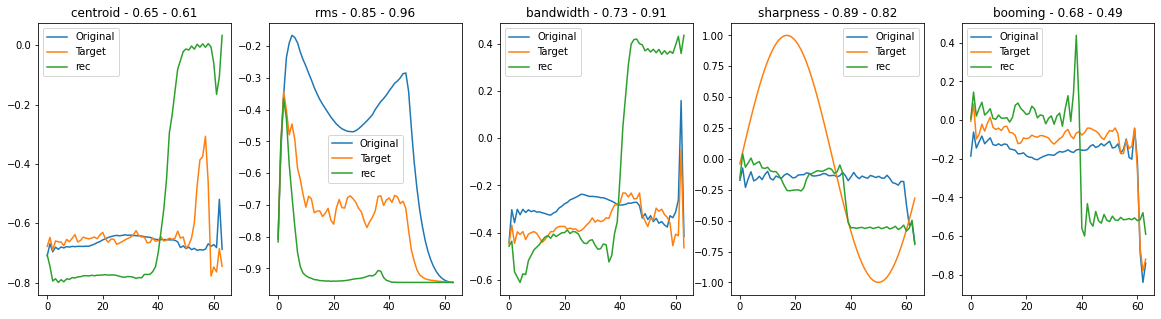

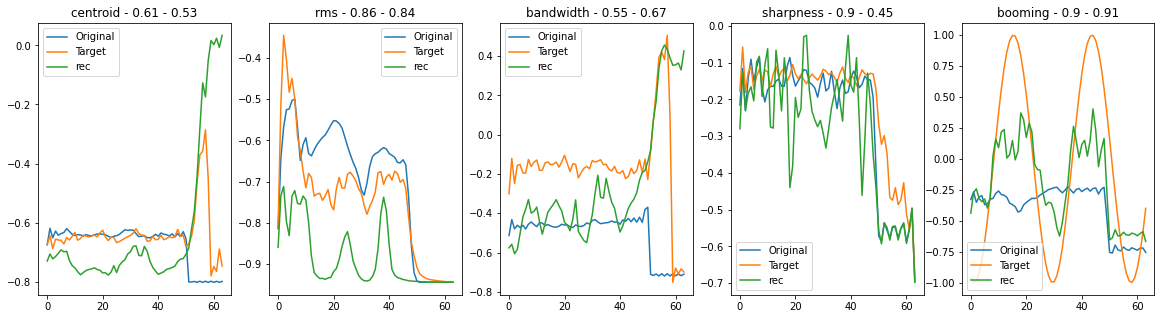

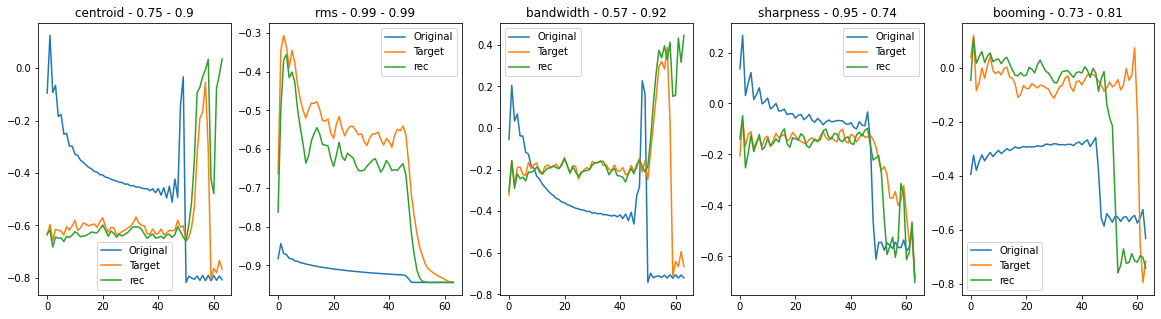

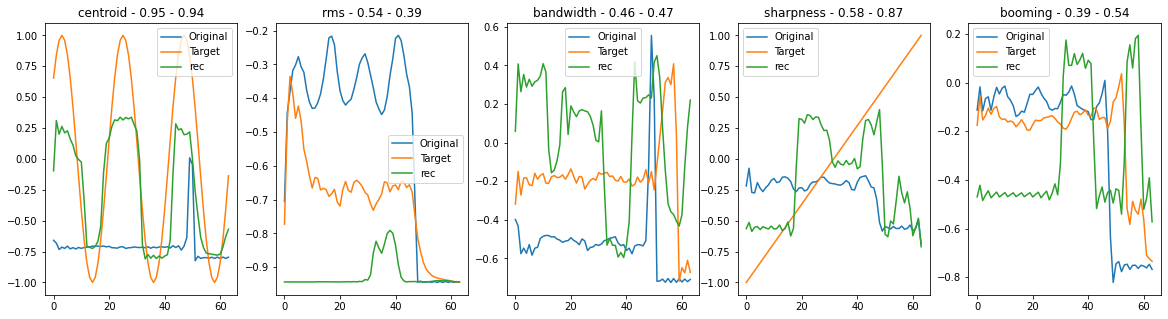

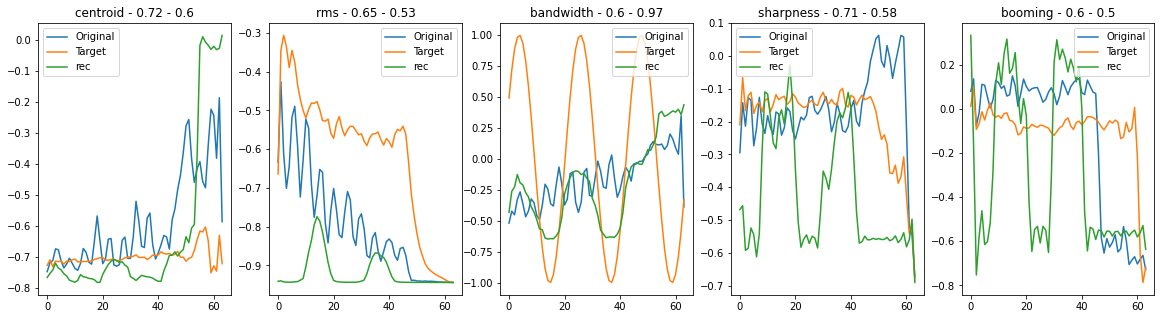

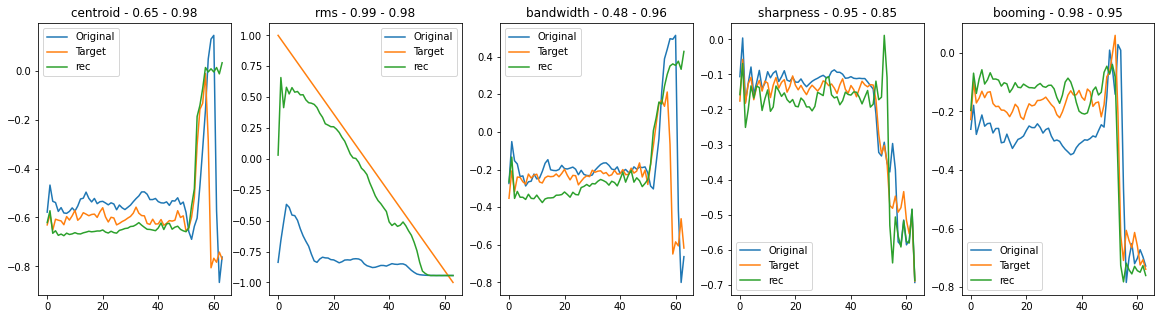

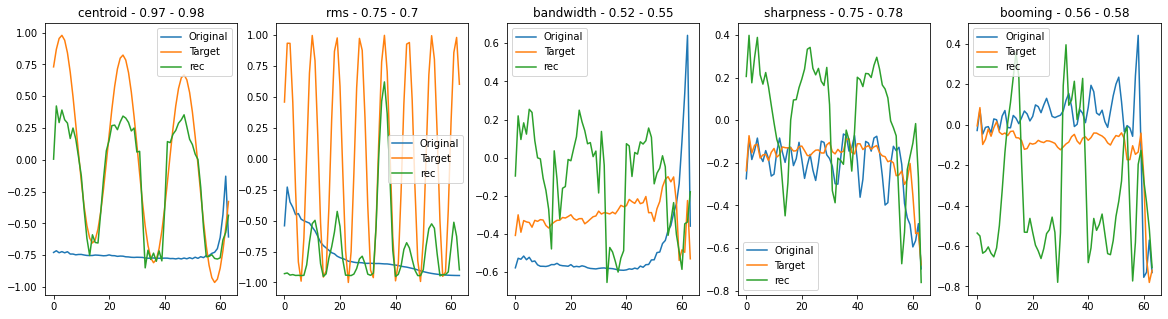

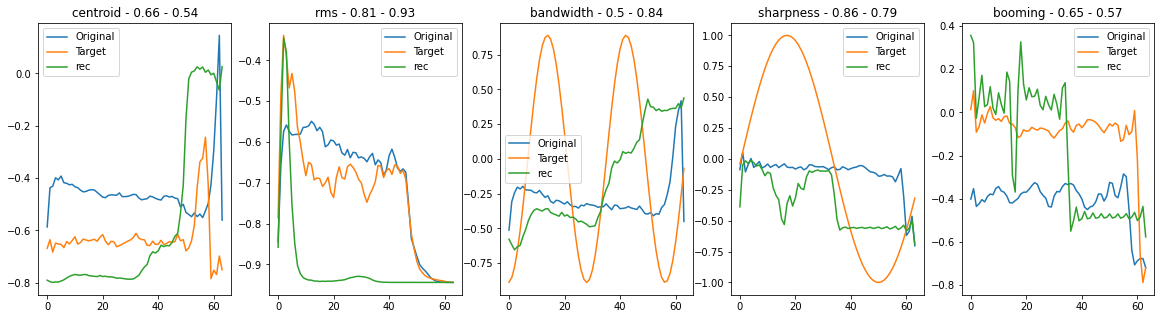

In [221]:
for j in range(8):
    f,axs = plt.subplots(1,5,figsize=(20,5))
    
    rms = features_swapped[j][1]
    mask = rms>-0.8
        
    for i,ax in enumerate(axs):
        ax.plot(features_normed[j].squeeze()[i],label="Original")
        ax.plot(features_swapped[j].squeeze()[i],label="Target")
        ax.plot(features_rec[j].squeeze()[i],label="rec")
        # ax.set_ylim(-1,1)
        
        
        # Compute without silence
        feat_in,feat_out = features_swapped[j][i],features_rec[j][i]
        cos = torch.nn.CosineSimilarity(dim=0 ,eps=1e-6)
        correlation =  (((cos(feat_in.reshape(-1)-feat_in.mean(),feat_out.reshape(-1)-feat_out.mean()) + 1) / 2)).item()
        
        # Compute with silence detection 
        
        feat_in,feat_out = features_swapped[j][i][mask],features_rec[j][i][mask]
        correlation_silenced =  (((cos(feat_in.reshape(-1)-feat_in.mean(),feat_out.reshape(-1)-feat_out.mean()) + 1) / 2)).item()
        
        
        
        # val = stats.pearsonr(feat_out.cpu(),feat_in.cpu())[0]
        
        ax.set_title(model.descriptors[i]+ " - "+str(np.round(correlation,2)) +" - " +  str(np.round(correlation_silenced,2)))
        ax.legend()

In [207]:
feat_out

tensor([], size=(0, 64))